In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Part 1

Read the chicago_crimes Hive table into Spark (25)  
  - a. Print basic summary statistics of the data set  
  - b. Drop the columns beat, ward, latitude and longitude columns  
  - c. Convert remaining columns to appropriate data types. Make your best assumptions by sampling the data. View schema again to ensure that data types have been converted.  
  - d. Add a month column and community name (from metadata) to the dataset


In [2]:
spark = SparkSession.builder.appName('ReadData').getOrCreate()
sc = spark.sparkContext
from pyspark.sql import HiveContext
hive_context = HiveContext(sc)

In [3]:
df = hive_context.table('sshepard.crimes')
header = df.first # there are some weird issues with the first row
df = df.filter(df.id!='ID')
df.show(5)

+-------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------+
|     id|case_number|         occurred_at|               block|iucr|       primary_type|         description|location_description|arrest|domestic|beat|district|ward|community_area|fbi_code|x_coordinate|y_coordinate|year|          updated_on|    latitude|    longitude|      location|
+-------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------+
|8380958|   HT612793|11/30/2011 11:59:...|     034XX W IOWA ST|0910|MOTOR VEHICLE THEFT|          AUTOMOBILE|              STREET| false|   false|11

## 1A 

Print basic summary statistics of the data set

In [4]:
df.describe().toPandas()

,summary,id,case_number,occurred_at,block,iucr,primary_type,description,location_description,arrest,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,count,6814395,6814395,6814395,6814395,6814395,6814395,6814395,6814395,6814395,...,6814395,6814395,6814395,6814395,6814395,6814395,6814395,6814395,6814395,6814395
1,mean,6277252.730256758,305161.84210526315,None,None,1128.186718362053,None,None,None,None,...,63.78641885791449,36.524408285806814,12.59535660662751,1128457.5611753017,1848895.3303074264,41507.38335457268,1836248.623304808,121.10712423146343,-66.33872971672801,39.56440842224943
2,stddev,3069437.1024770066,134932.50160327618,None,None,811.5576020722564,None,None,None,None,...,250.19886601945146,21.799399253154053,9.20852794451375,202340.05942940037,262336.5661546787,213225.027851179,285472.1340467324,4142.176601810388,6306.932722317442,40.279165878225044
3,min,1000,,01/01/2001 01:00:00 AM,0000X E 100 PL,0110,ARSON,"""ATT: TRUCK",,"BIKE NO VIN""",...,,,,,,,,,,
4,max,9999999,ZZZ199957,12/31/2018 12:55:00 AM,XX UNKNOWN,9901,WEAPONS VIOLATION,WIREROOM/SPORTS,YMCA,true,...,true,false,9,9,9,75,2019,42.022910333,42.020537666,42.022618208


## 1B

Drop the columns beat, ward, latitude and longitude columns

In [5]:
df.columns

['id',
 'case_number',
 'occurred_at',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'beat',
 'district',
 'ward',
 'community_area',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'latitude',
 'longitude',
 'location']

In [6]:
df = df.drop("beat", "ward", "latitude", "longitude")

In [7]:
df.columns

['id',
 'case_number',
 'occurred_at',
 'block',
 'iucr',
 'primary_type',
 'description',
 'location_description',
 'arrest',
 'domestic',
 'district',
 'community_area',
 'fbi_code',
 'x_coordinate',
 'y_coordinate',
 'year',
 'updated_on',
 'location']

## 1C

Convert remaining columns to appropriate data types. Make your best assumptions by sampling the
data. View schema again to ensure that data types have been converted.


In [8]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- case_number: string (nullable = true)
 |-- occurred_at: string (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: string (nullable = true)
 |-- domestic: string (nullable = true)
 |-- district: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: string (nullable = true)
 |-- y_coordinate: string (nullable = true)
 |-- year: string (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- location: string (nullable = true)



In [9]:
df2 = df.withColumn("id", df.id.cast(types.IntegerType()))
df2 = df2.withColumn("occurred_at", unix_timestamp("occurred_at", "MM/dd/yyyy hh:mm:ss aa"))
df2 = df2.withColumn("occurred_at", df2.occurred_at.cast(types.TimestampType()))
df2 = df2.withColumn("year_month", from_unixtime(unix_timestamp("occurred_at", "MM/dd/yyyy hh:mm:ss aa"), "yyy-MM"))
df2 = df2.withColumn("updated_on", unix_timestamp("updated_on", "MM/dd/yyyy hh:mm:ss aa"))
df2 = df2.withColumn("updated_on", df2.updated_on.cast(types.TimestampType()))
df2 = df2.withColumn("arrest", df.arrest.cast(types.BooleanType()))
df2 = df2.withColumn("domestic", df.domestic.cast(types.BooleanType()))
df2 = df2.withColumn("x_coordinate", df.x_coordinate.cast(types.IntegerType()))
df2 = df2.withColumn("y_coordinate", df.y_coordinate.cast(types.IntegerType()))
df2 = df2.withColumn("year", df.year.cast(types.IntegerType()))

In [10]:
df2.printSchema()

root
 |-- id: integer (nullable = true)
 |-- case_number: string (nullable = true)
 |-- occurred_at: timestamp (nullable = true)
 |-- block: string (nullable = true)
 |-- iucr: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- description: string (nullable = true)
 |-- location_description: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- district: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- fbi_code: string (nullable = true)
 |-- x_coordinate: integer (nullable = true)
 |-- y_coordinate: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- updated_on: timestamp (nullable = true)
 |-- location: string (nullable = true)
 |-- year_month: string (nullable = true)



## 1D

Add a month column and community name (from metadata) to the dataset


In [11]:
df2 = df2.withColumn("date", F.to_date("occurred_at"))
df2 = df2.withColumn("dow", F.dayofweek("occurred_at"))
df2 = df2.withColumn("month", F.month(F.to_date("occurred_at")))
df2 = df2.withColumn("year", F.year(F.to_date("occurred_at")))

In [12]:
ca = spark.read.csv("data/community_areas.csv", inferSchema=True, header=True)

In [13]:
ca.show(2)

+--------------+--------------+
|community_area|community_name|
+--------------+--------------+
|             1|   Rogers Park|
|             2|    West Ridge|
+--------------+--------------+
only showing top 2 rows



In [14]:
df3 = df2.join(ca, on="community_area")

In [15]:
df3.select("id", "community_name").show(2)

+-------+--------------+
|     id|community_name|
+-------+--------------+
|8380958| Humboldt Park|
|8380959|North Lawndale|
+-------+--------------+
only showing top 2 rows



# Part 2

Explore by crime attributes (25)  
  - a. Group and count crimes where description begins with the word “aggravated”  
  - b. Which crime type is the most prevalent in apartments and which community has it occurred the most  
  - c. What is the maximum number of weapons violations per month that occurred in 2018.  
  - d. What percentage of the domestic crimes led to an arrest ?

## 2A

Group and count crimes where description begins with the word “aggravated”

In [16]:
df3.filter(df3.description.like("%AGGRAVATED%"))\
    .groupby(df3.description)\
    .count()\
    .sort("count").orderBy(["count"], ascending=[0])\
    .show()

+--------------------+-----+
|         description|count|
+--------------------+-----+
|AGGRAVATED: OTHER...|81411|
| AGGRAVATED: HANDGUN|76520|
|AGGRAVATED:KNIFE/...|49856|
|AGGRAVATED DOMEST...|18513|
|      NON-AGGRAVATED|14377|
|          AGGRAVATED|14184|
|AGGRAVATED DOMEST...|12721|
|AGGRAVATED VEHICU...| 8293|
|   AGGRAVATED: OTHER| 4164|
|AGGRAVATED DOMEST...| 3657|
|AGGRAVATED: OTHER...| 2607|
|AGGRAVATED PO: OT...| 2563|
|AGGRAVATED OF A S...| 2257|
|AGGRAVATED DOMEST...| 1546|
|AGGRAVATED PO: HA...| 1141|
|ATTEMPT NON-AGGRA...| 1094|
| ATTEMPT: AGGRAVATED|  936|
|AGGRAVATED: KNIFE...|  926|
|AGGRAVATED OF A C...|  673|
|AGGRAVATED FINANC...|  653|
+--------------------+-----+
only showing top 20 rows



## 2B

Which crime type is the most prevalent in apartments and which community has it occurred the most.

In [17]:
df3.filter(df3.location_description=="APARTMENT")\
    .groupby(df3.primary_type)\
    .count()\
    .sort("count").orderBy(["count"], ascending=[0])\
    .show(5)

+---------------+------+
|   primary_type| count|
+---------------+------+
|        BATTERY|233215|
|       BURGLARY|106841|
|CRIMINAL DAMAGE| 75866|
|          THEFT| 66371|
|  OTHER OFFENSE| 59801|
+---------------+------+
only showing top 5 rows



In [18]:
df3.filter(((df3.location_description=="APARTMENT") & (df3.primary_type=="BATTERY")))\
    .groupby(df3.community_name)\
    .count()\
    .sort("count").orderBy(["count"], ascending=[0])\
    .show(5)

+--------------------+-----+
|      community_name|count|
+--------------------+-----+
|              Austin|20019|
|         South Shore|17903|
|Greater Grand Cro...|10337|
|      North Lawndale|10024|
|           Englewood| 9750|
+--------------------+-----+
only showing top 5 rows



Battery is the most prevalent crime and it occurs most often in Austin.

## 2C

What is the maximum number of weapons violations per month that occurred in 2018.

In [19]:
tmp2c = df3.filter((df3.year==2018) & (df3.primary_type=='WEAPONS VIOLATION'))\
            .groupby(df3.month)\
            .count()\
            .sort("count")\
            .orderBy(["count"], ascending=[0])\
            .toPandas()
tmp2c

,month,count
0,8,561
1,7,548
2,5,541
3,6,497
4,9,486
5,10,451
6,12,447
7,1,410
8,11,407
9,4,399


Maximum number of monthly weapons violations in 2018: 561


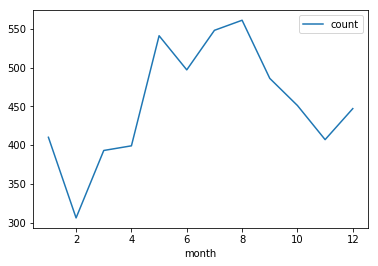

In [20]:
tmp2c.sort_values('month').plot(x='month', y='count')
print('Maximum number of monthly weapons violations in 2018:', tmp2c['count'].max())

The month of August is the peak of weapons violations in 2018.

## 2D

What percentage of the domestic crimes led to an arrest ?

In [21]:
df3.filter(df3.domestic==True).groupby(df3.arrest).count().show()

+------+------+
|arrest| count|
+------+------+
|  null|   810|
|  true|161540|
| false|656196|
+------+------+



In [22]:
df3.filter(df3.domestic==True)\
    .withColumn('arrest', df3.arrest.cast(types.IntegerType()))\
    .agg({'arrest': 'mean'}).collect()

[Row(avg(arrest)=0.1975454180811411)]

19.7% of domestic crimes lead to an arrest.

# Part 3

Explore by date and time (25)
  - a. Which months have the most and the least crimes on average  
  - b. Which day of the week has the highest number of crimes on average  
  - c. Which date had the most number of homicides in the dataset  
  - d. How many days passed between this date and the next highest number of homicides

## 3A

Which months have the most and the least crimes on average

In [23]:
df3.filter(df3.year < 2019)\
    .groupby(df3.year, df3.month)\
    .count()\
    .groupby(df3.month)\
    .agg(F.avg('count').alias('avg_crimes'))\
    .sort("avg_crimes").orderBy(["avg_crimes"], ascending=[0])\
    .show()

+-----+------------------+
|month|        avg_crimes|
+-----+------------------+
|    7|32596.722222222223|
|    8|32290.222222222223|
|    5|31306.333333333332|
|    6|31090.166666666668|
|   10| 30659.61111111111|
|    9| 30315.38888888889|
|   11|           27541.5|
|    4|           27530.5|
|    3| 26894.61111111111|
|   12|26084.944444444445|
|    1|25370.166666666668|
|    2|22252.277777777777|
+-----+------------------+



July has the most number of crimes and average and February the least.

## 3B

Which day of the week has the highest number of crimes on average


In [24]:
df3.filter(df3.year < 2019)\
    .groupby(df3.date, df3.dow)\
    .count()\
    .groupby(df3.dow)\
    .agg(F.avg('count').alias('avg_crimes'))\
    .sort("avg_crimes").orderBy(["avg_crimes"], ascending=[0])\
    .show()

+---+-----------------+
|dow|       avg_crimes|
+---+-----------------+
|  6|993.7806176783813|
|  4|951.9456869009584|
|  3|945.5889243876464|
|  5|942.4984025559105|
|  7|939.9595314164004|
|  2|928.2606382978723|
|  1|889.9318423855165|
+---+-----------------+



Friday has the highest average number of crimes with Sunday the lowest average.

## 3C

Which date had the most number of homicides in the dataset

In [25]:
tmp3c = df3\
    .filter(df3.primary_type == "HOMICIDE")\
    .groupby(df3.date)\
    .count()\
    .sort("count").orderBy(["count"], ascending=[0])

In [26]:
tmp3c.show(5)

+----------+-----+
|      date|count|
+----------+-----+
|2003-07-05|   10|
|2015-09-02|   10|
|2016-02-04|    9|
|2016-09-05|    9|
|2018-08-05|    8|
+----------+-----+
only showing top 5 rows



9/2/2015 and 7/5/2003 are the top two days for homicide in the dataset.

## 3D

How many days passed between this date and the next highest number of homicides

In [27]:
days = tmp3c.select("date").head(2)
days[1][0] - days[0][0]

datetime.timedelta(-4442)

There are 4442 days between the first and second instance of 10 homicides.

# Part 4

Transform Spark results to Pandas dataframe and plot the following (25)  
  - a. Cross-tabluate Crime Types vs Location Description  
  - b. Plot monthly time series chart of all crimes for the last 5 years  
  - c. Plot a year over year comparison for the last 2 years (2017, 2018) for the top 5 crime types  
  - d. Plot a horizontal multi-line chart which compare total annual crimes of following communities –
Edgewater, Lincoln Park, Loop and Hyde Park

## 4A

Cross-tabluate Crime Types vs Location Description

In [28]:
tmp4a = df3.crosstab('primary_type', 'location_description').toPandas()

In [29]:
tmp4a.head()

,primary_type_location_description,,BUS,SCOOTER,"""CTA """"L"""" PLATFORM""","""CTA """"L"""" TRAIN""","""SCHOOL","""VEHICLE - OTHER RIDE SHARE SERVICE (E.G.",ABANDONED BUILDING,AIRCRAFT,...,VEHICLE - OTHER RIDE SERVICE,VEHICLE NON-COMMERCIAL,VEHICLE-COMMERCIAL,VEHICLE-COMMERCIAL - ENTERTAINMENT/PARTY BUS,VEHICLE-COMMERCIAL - TROLLEY BUS,VESTIBULE,WAREHOUSE,WOODED AREA,YARD,YMCA
0,CRIMINAL TRESPASS,1,0,0,0,0,7724,1,1527,2,...,0,1170,74,0,0,0,370,0,0,0
1,OFFENSE INVOLVING CHILDREN,0,0,0,0,0,1328,0,25,0,...,0,247,7,0,2,0,3,0,0,0
2,NARCOTICS,1,0,0,0,0,12220,5,2746,4,...,2,19634,158,0,0,0,87,0,0,0
3,RITUALISM,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,INTIMIDATION,0,0,0,0,0,237,0,0,0,...,0,8,1,0,0,0,4,0,0,0


In [30]:
tmp4a = tmp4a.fillna(0)
tmp4a = tmp4a.set_index('primary_type_location_description')

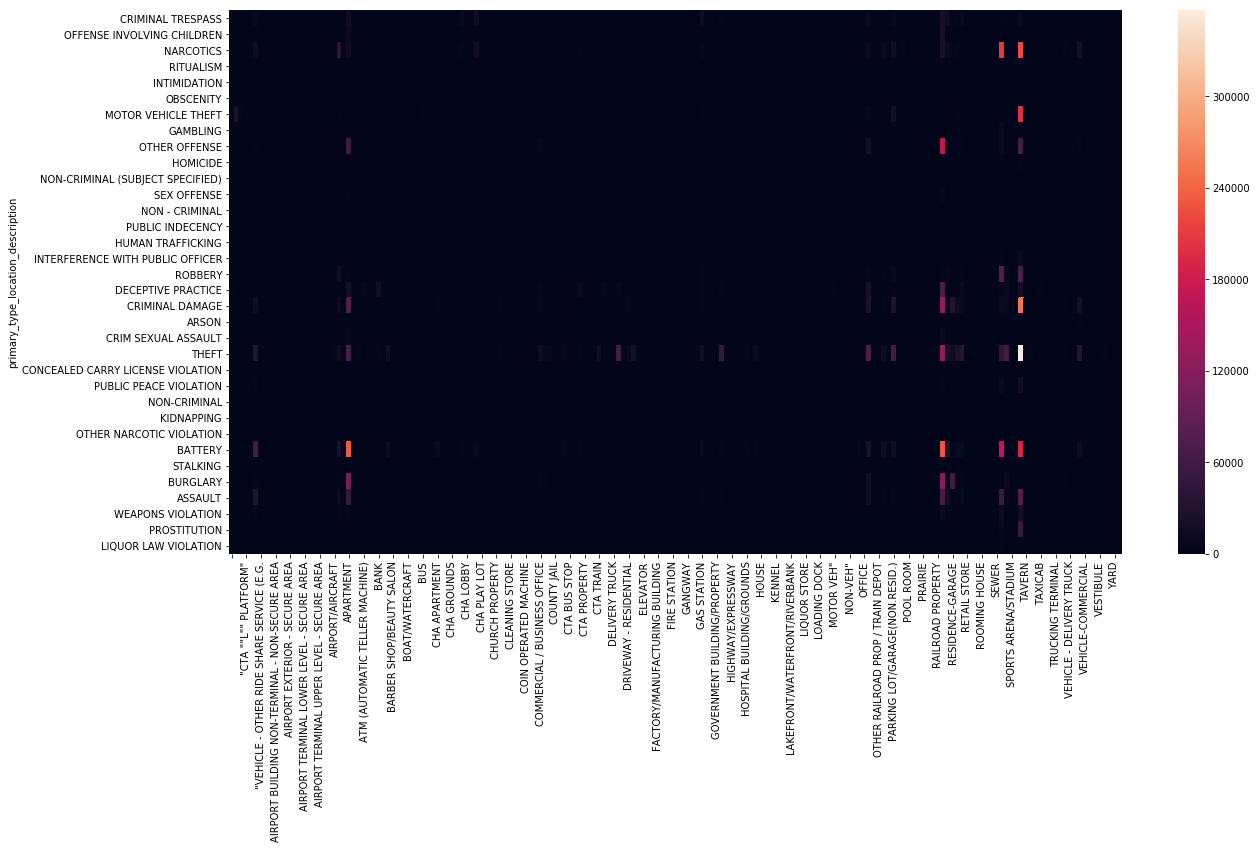

In [31]:
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(tmp4a, ax=ax)

## 4B

Plot monthly time series chart of all crimes for the last 5 years

In [32]:
tmp4b = df3.filter(df3.year < 2019).groupby(df3.year_month).count().toPandas()
tmp4b = tmp4b.sort_values(['year_month']).reset_index().drop('index', axis=1)
tmp4b = tmp4b[~tmp4b.year_month.isna()]

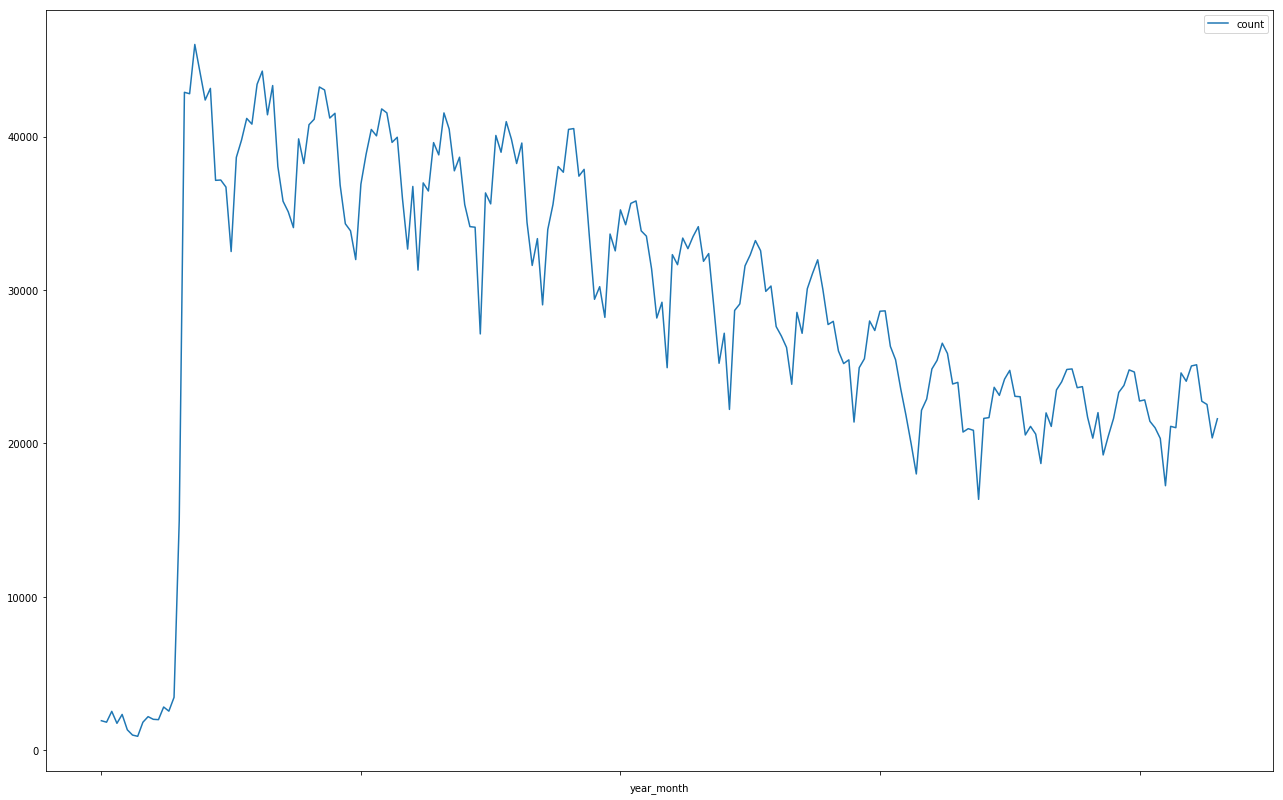

In [33]:
tmp4b.plot(x='year_month', y='count', figsize=(22,14))

## 4C

Plot a year over year comparison for the last 2 years (2017, 2018) for the top 5 crime types

In [34]:
tmp4c = df3.filter(df3.year < 2019)\
    .groupby(df3.year, df3.primary_type)\
    .count()\
    .sort("count").orderBy(["count"], ascending=[0])

window = Window.partitionBy(tmp4c['year']).orderBy(tmp4c['count'].desc())

tmp4c = tmp4c\
    .select('*', F.rank().over(window).alias('rank'))\
    .filter(F.col('rank') <= 5)\
    .sort("year").orderBy(["year"], ascending=[0])\
    .toPandas()

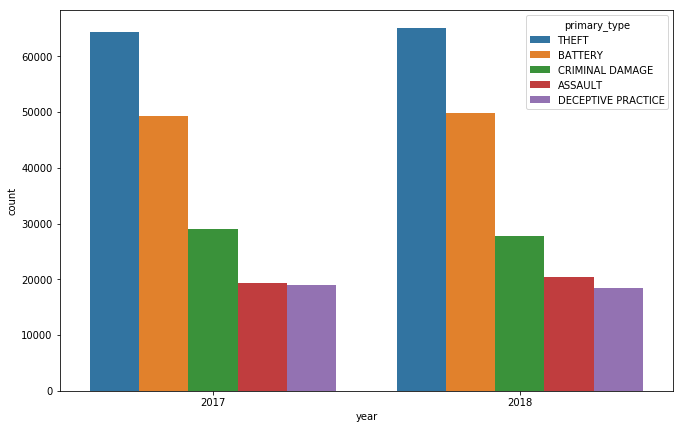

In [35]:
fig, ax = plt.subplots(figsize=(11,7))
sns.barplot(x='year', y='count', hue='primary_type', data=tmp4c[tmp4c.year >= 2017], ax=ax)

Same top five categories in both years, but in 2017, deceptive practice was number four where as in 2018 it was number 5.

## 4D

Plot a horizontal multi-line chart which compare total annual crimes of following communities –
Edgewater, Lincoln Park, Loop and Hyde Park

In [36]:
tmp4d = df3\
    .filter(df3.year<2019)\
    .filter(df3.community_area.isin([77, 7, 32, 41]))\
    .groupby(df3.community_name, df3.year)\
    .count().toPandas()

In [37]:
tmp4d['year'] = tmp4d['year'].astype('str')

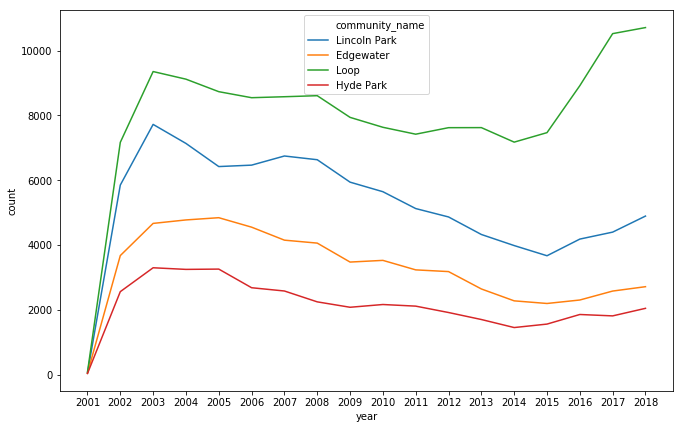

In [38]:
fig, ax = plt.subplots(figsize=(11,7))  
sns.lineplot(x='year', y='count', hue='community_name', data=tmp4d, ax=ax)

Total annual crimes across the four communities has gone up since 2014 with most crimes in the loop every year than the other three areas.